<a href="https://colab.research.google.com/github/predicthq/phq-data-science-docs/blob/master/severe-weather-events/part_1_data_engineering.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### SEVERE-WEATHER EVENTS DATA SCIENCE GUIDES

# Part 1 Data Engineering

<b>A How-To Guide to extracting data from PredictHQ's Severe-Weather Events data. 

    
The aim of this notebook is showcase how the PHQ Events API could be used to extract severe-weather events for a location and time of your choice.

- [Setup](#setup)
- [Access Token](#access_token)
- [SDK Parameters](#setting_params) 
- [Query Unattended Events](#query_unattended_events)
- [Output DataFrame](#output_dataframe)
- [Appendix 1 - Finding place_id](#appendix-1)
- [Appendix 2: Parsing geojson with Shapely](#appendix-2)


<a id='setup'></a>
# Setup


If using Google Colab uncomment the following code block.

In [12]:
# %%capture
# !git clone https://github.com/predicthq/phq-data-science-docs.git
# %cd phq-data-science-docs/unattended-events
# !pip install predicthq>=1.10.0 timezonefinder pandas==1.1.5 shapely==1.7.1


If running locally, set up a Python environment using [requirements.txt](https://github.com/predicthq/phq-data-science-docs/blob/master/unattended-events/requirements.txt) file which is shared alongside the notebook.

These requirements can be installed by runing the command `pip install -r requirements.txt`


In [2]:
import pandas as pd
from predicthq import Client
from timezonefinder import TimezoneFinder
import requests

# To display more columns and with a larger width in the DataFrame
pd.set_option("display.max_columns", 50)
pd.options.display.max_colwidth = 100

<a id='access_token'></a>
# Access Token
An Access Token is required to query the API. You can checked out our [API Quickstart](../../guides/quickstart/) page if you want to create an account or an access token.


In [15]:
# Replace Access Token with own access token.
ACCESS_TOKEN = 'REPLACE_WITH_ACCESS_TOKEN'
phq = Client(access_token=ACCESS_TOKEN)

<a id='setting_params'></a>
# SDK Parameters
To search for Severe-Weather Events, start by building a parameter dictionary and adding the required filters.

In [16]:
parameters = dict()

#### Location
Severe-weather events are specific to the location that they impact. We use polygons to show the geographic area impacted by the event. Polygons are used in our backend to filter events and return events that impact the selected location when you call our Events' API to get Severe-Weather Events. 

The location parameter could be set in one of the following ways:  

  1) Using the ```within``` parameter, which contains ```latitude```, ```longitude``` of the location with a ```radius```, and a ```unit``` for the radius. This would return events whose polygon intersects with the radius specified. Please note that using ```within``` would return more accurate results than ```place_id``` but bear in mind that ```radius``` should have an integer value greater than 0 (eg: `1m`). The result is relatively insensitive to the setting of radius as Severe-Weather Events have large location scopes. We recommend a radius of `1m` if you want to filter where the events polygon overrlaps the latitude and longitude of your location.
  
  2) Using a list of place_ids, returns events which have a geo-scoped ```place_id``` matching the given ```place_id``` or that intersects it's polygon. For example if you specify the place id for Seattle you will get events whose polygons overlap with the metropolitan area of Seattle.
   
Note: This notebook uses the state of ```New York``` as an example location. You can modify this to suit your location(s) of interest.

In [17]:
# Using latitude, longitude and a radius
latitude, longitude = (40.7079, -74.0115) # LAT, LONG for centre of New York City
radius = 1
radius_unit = "m"

within = f"{radius}{radius_unit}@{latitude},{longitude}"

Alternatively, we could have used a list of ```place_id``` for our search (See our Appendix on Place IDs for detailed explanation).

In [18]:
# Using a list of place_id
place_ids = [5128638] # Place ID for state of New York https://www.geonames.org/5128638/new-york.html

You can use either ```within``` or place_id as a filter but you can not use both.

In [19]:
parameters.update(within=within)  # Comment if you want to use place_ids
# parameters.update(place__scope=place_ids)  # Comment if you want to use lat and long

#### Date "YYYY-MM-DD"

To define the period of time for which Severe-Weather Events will be returned, set the greater than or equal (active.gte) and less than or equal (active.lte) parameters. This will select all Severe-Weather Events that are active within this period.

You could also use either of these parameters depending on your time period of interest:

```gte - Greater than or equal.``` <br>
```gt - Greater than.```<br>
```lte - Less than or equal.```<br>
```lt - Less than.```<br>


The default example in this notebook is to search for the whole of 2020.

In [20]:
start_time = "2021-12-01"
end_time = "2022-01-31"
parameters.update(active__gte=start_time)
parameters.update(active__lte=end_time)

#### Timezone 
By setting the timezone for the location of interest, the appropriate events will be returned.(<a href="https://en.wikipedia.org/wiki/List_of_tz_database_time_zones">tz database</a>)

For our New York example, the timezone would be ```America/New_York```. 
Use the `TimezoneFinder()` to find it for our location of interest.

In [21]:
timezone = TimezoneFinder().timezone_at(lat=latitude, lng=longitude)
print(timezone)

America/New_York


In [22]:
parameters.update(active__tz=timezone)

#### Categories
Set the category to `severe-weather`.


In [23]:
categories = ["severe-weather"]
parameters.update(category=categories)

#### Checking the parameters
Finally, let's take a look at the parameters we have set for our search.

In [24]:
parameters

{'within': '1m@40.7079,-74.0115',
 'active__gte': '2021-12-01',
 'active__lte': '2022-01-31',
 'active__tz': 'America/New_York',
 'category': ['severe-weather']}

You can check out the full list of available parameters that you could use in querying Severe-Weather Events at our [Events Resource page](../../resources/events/).

<a id='calling_api'></a>
# Calling the PredictHQ API and Fetching Events

In this step, we use PHQ Python SDK Client to query and fetch events based on the parameters we defined above.

In [25]:
results = []

# Iterating through all the events that match our criteria and adding them to our results
for event in phq.events.search(parameters).iter_all():
    results.append(event.to_dict())

# Converting the results to a DataFrame
event_df = pd.DataFrame(results)

<a id='exploring_df'></a>
# Exploring the Result DataFrame and Storing it
We take a look at the result data and select the most important fields for our use case.

In [26]:
event_df.head()

,cancelled,category,country,deleted_reason,description,duplicate_of_id,duration,end,first_seen,geo,id,impact_patterns,labels,location,parent_event,place_hierarchies,postponed,relevance,scope,start,state,timezone,title,updated,aviation_rank,brand_safe,entities,local_rank,phq_attendance,predicted_end,private,rank
0,None,severe-weather,US,None,- WHAT: Up to one half foot of inundation above ground level expected in vulnerable areas near ...,None,10800,2022-01-04 16:00:00+00:00,2022-01-03 21:15:45+00:00,"{'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-74.02203499999996, 40.68399900000003],...",3CXrxry7dochGvGpiz,"[{'vertical': 'retail', 'impact_type': 'phq_rank', 'impacts': [{'date_local': datetime.date(2022...","[flood, weather, weather-warning]","[-73.9662196457, 40.781758233]",None,"[[6295630, 6255149, 6252001, 5128638, 5128581], [6295630, 6255149, 6252001, 5128638, 5128594], [...",None,0.0,county,2022-01-04 13:00:00+00:00,active,America/New_York,Coastal Flood Statement,2022-01-04 08:45:35+00:00,None,None,[],None,None,None,False,49
1,None,severe-weather,US,None,- WHAT: Up to one half foot of inundation above ground level expected in vulnerable areas near ...,None,18000,2022-01-03 16:00:00+00:00,2022-01-02 21:30:34+00:00,"{'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[-74.02203499999996, 40.68399900000003],...",AscHYiUqf4Qamg8Cg6,"[{'vertical': 'retail', 'impact_type': 'phq_rank', 'impacts': [{'date_local': datetime.date(2022...","[flood, weather, weather-warning]","[-73.9662196457, 40.781758233]",None,"[[6295630, 6255149, 6252001, 5128638, 5128581], [6295630, 6255149, 6252001, 5128638, 5128594], [...",None,0.0,county,2022-01-03 11:00:00+00:00,active,America/New_York,Coastal Flood Statement,2022-01-03 09:15:46+00:00,None,None,[],None,None,None,False,49


It is important to understand the output data. The most useful fields are the following:
- ```id``` The unique id of each event.
- ```title``` The title of each event.
- ```description``` The description of each event.
- ```start``` The start time of each event.
- ```end``` The end time of each event.
- ```duration``` Duration of event in seconds.
- ```category``` Category of events. e.g `severe-weather`
- ```labels``` Labels of each event.
- ```country``` Country of each event.
- ```rank``` PHQ rank of each event.
- ```aviation_rank``` Aviation rank of each event.
- ```location``` Latitude and longitude of each event.
- ```place_hierarchies``` The hierarchies place ids.
- ```scope``` The scope of each event.
- ```first_seen``` The time when we received this event.
- ```impact_patterns``` The demand impact pattern for the event indicating leading and lagging impacts of the event.

Check out [Events Resource page](../../resources/events/) for more information on all these fields.

In [148]:
# Selecting the target fields
event_df = event_df[
    [
        "id",
        "title",
        "description",
        "start",
        "end",
        "duration",
        "category",
        "labels",
        "country",
        "rank",
        "aviation_rank",
        "location",
        "place_hierarchies",
        "scope",
        "first_seen",
        "impact_patterns"
    ]
]

In [162]:
# Creating a filename for our DataFrame and saving our final DataFrame as a Pickle file
if "within" in parameters:
    file_name = (
        f"radius{radius}{radius_unit}_{latitude}_{longitude}_{start_time}_{end_time}"
    )
else:
    file_name = f"place_ids_{'_'.join(place_ids)}_{start_time}_{end_time}"

event_df.to_pickle(f"data/event_data/{file_name}.pkl")
print(f"DataFrame saved to data/event_data/{file_name}.pkl")

DataFrame saved to data/event_data/radius1m_40.7079_-74.0115_2021-12-01_2022-01-31.pkl


<a id='appendix-1'></a>
## Appendix 1: Finding ```place_id``` 

Here is a guide on how to link between store locations and ```place_id```. Here the ```location``` could be a city, a state, a country or a continent. 

 - Query ```place_id``` based on ```location```
 - Query ```place_hierarchies``` based on ```latitude, longitude```
 - Query ```location``` based on ```place_id```

The full list of parameters that you could use in your query is documents at our [Places API page](../../resources/places/).<br>
PredictHQ uses the geonames places convention https://www.geonames.org/ 

#### 1) Query ```place_id``` based on ```location```

By using PredictHQ Places API, you can find the ```place_id``` for a specific ```location```. By calling the API and setting ```q``` to ```location```, the API will return the most relevant ```place_id```. Taking the top ```place_id``` will provide the most relevant ```place_id``` the ```location``` is in.

In [31]:
# Example locations.
locations = ["New York", "California", "United States", "North America"]

place_id_lookup = pd.DataFrame()

for location in locations:
    response = requests.get(
        url="https://api.predicthq.com/v1/places/",
        headers={
            "Authorization": "Bearer {}".format(ACCESS_TOKEN),
            "Accept": "application/json",
        },
        params={"q": location},
    )

    data = response.json()
    df = pd.json_normalize(data["results"])
    place_id_lookup = place_id_lookup.append(df.iloc[0], ignore_index=True)

In [32]:
place_id_lookup[["id", "name", "type"]]

,id,name,type
0,5128581,New York,locality
1,5332921,California,region
2,6252001,United States,country
3,6255149,North America,continent


#### 2) Query ```place_hierarchies``` based on ```latitude, longitude```

By using PredictHQ Places Hierarchies API, you can find the  ```place_hierarchies``` for a specific ```latitude, longitude```. By calling the API and setting ```location.origin``` to ```latitude, longitude```, the API will return the most relevant ```place_hierarchies```.

In [8]:
# Example locations.
latitude_longitudes = [[40.1459, -74.226]]

place_hierarchies_lookup = pd.DataFrame()

for latitude_longitude in latitude_longitudes:
    latitude, longitude = latitude_longitude
    response = requests.get(
        url="https://api.predicthq.com/v1/places/hierarchies",
        headers={
            "Authorization": "Bearer {}".format(ACCESS_TOKEN),
            "Accept": "application/json",
        },
        params={"location.origin": f"{latitude},{longitude}"},
    )

    data = response.json()
    df = pd.DataFrame(data)
    df["latitude"] = latitude
    df["longitude"] = longitude
    place_hierarchies_lookup = place_hierarchies_lookup.append(df, ignore_index=True)

In [9]:
place_hierarchies_lookup

,place_hierarchies,latitude,longitude
0,"[{'place_id': '6295630', 'type': 'planet'}, {'place_id': '6255149', 'type': 'continent'}, {'plac...",40.1459,-74.226
1,"[{'place_id': '6295630', 'type': 'planet'}, {'place_id': '6255149', 'type': 'continent'}, {'plac...",40.1459,-74.226


For each ```latitude, longitude```, the response might include more than one hierarchy. The reason for this is we try to match the closest place's hierarchy but we also include the closest major city's hierarchy within a radius of 50km. This only applies if the level is below region and, if it exists, the major city's hierarchy will always be the second row of the DataFrame.

#### 3) Query ```location``` based on ```place_id```

By using PredictHQ Places API, you can find the ```location``` for a specific ```place_id```. By calling the API and setting ```id``` to ```place_id```, the API will return the most relevant ```location```. Taking the top ```location``` will provide the most relevant ```location``` the ```place_id``` is in.

In [29]:
# Example locations.
place_ids = ["5098278", "5104865"]

location_lookup = pd.DataFrame()

for place_id in place_ids:
    response = requests.get(
        url="https://api.predicthq.com/v1/places/",
        headers={
            "Authorization": "Bearer {}".format(ACCESS_TOKEN),
            "Accept": "application/json",
        },
        # The id could be a comma-separated list of place_ids. In this example, the
        # events are queried based on each place_id.
        params={"id": place_id},
    )

    data = response.json()
    df = pd.json_normalize(data["results"])
    location_lookup = location_lookup.append(df.iloc[0], ignore_index=True)

In [30]:
location_lookup[["id", "name", "type"]]

,id,name,type
0,5098278,Freehold,locality
1,5104865,Southard,locality


<a id='appendix-2'></a>
## Appendix 2: Parsing geojson with Shapely 

In this part, we take a brief look on how you can parse the geojson `geometry` field using [Shapely](https://github.com/Toblerity/Shapely). 

Let's say we `event` with geojson data in it's `geo.geometry` field. We can parse it using `shape` fucntion from Shapely.

In [1]:
from shapely.geometry import shape


event = {
    "id": "268aCtdaPgDJNurMeP",
    "title": "Flood Warning",
    "geo": {
        "geometry": {
            "type": "Polygon",
            "coordinates": [
                [
                    [-94.15, 39.1599999],
                    [-94.17, 39.220000000000006],
                    [-93.86, 39.25000000000001],
                    [-93.84, 39.18000000000001],
                    [-94.05, 39.11000000000001],
                    [-94.15, 39.1599999],
                ]
            ],
        }
    }
    # other fields omitted...
}

Passing the `geo.geometry` field into the shape function, would return a shapely object, in this case a `Polygon`.

In [2]:
# retrieving event's geojson field
event_geojson = event['geo']['geometry']

# parsing the geojson object using shape from shapely
parsed_polygon = shape(event_geojson)

In [3]:
# checking the type of the object
print(type(parsed_polygon))

<class 'shapely.geometry.polygon.Polygon'>


In [4]:
# printing the polygon object
print(parsed_polygon)

POLYGON ((-94.15000000000001 39.1599999, -94.17 39.22000000000001, -93.86 39.25000000000001, -93.84 39.18000000000001, -94.05 39.11000000000001, -94.15000000000001 39.1599999))


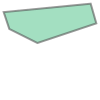

In [5]:
# displaying the polygon shape
parsed_polygon

Shapely comes with many built-in methods that we could use to geospatial operations. In this example, we would be looking into how we can get check if a given point (lattitude, longitude) is inside the polygon object. 

First, let's define a point, this point would be preceisly within meters of the polygon border but still INSIDEN the polygon. We are gonna check wether this point intersects with the polygon with and without projection using shapely's built-in methods.

In [116]:
from shapely.geometry import Point


# Points are defined in (lon, lat) format
point_1 = Point(-94.096, 39.165)
point_2 = Point(-93.819, 39.131)

Checking whether the point is on/inside the polygon without projection:

In [117]:
# Checking to see point_1 intersects with parsed_polygon
parsed_polygon.intersects(point_1)

True

In [118]:
# Checking to see point_1 intersects with parsed_polygon
parsed_polygon.intersects(point_2)

False

We can also use this method in a pandas DataFrame. Let try this by loading building a simple DataFrame which has two events with `id` , `title` and `geo` fields only:

In [122]:
import pandas as pd

In [143]:
events_list = [
    {
        "id": "268aCtdaPgDJNurMeP",
        "title": "Flood Warning",
        "geo": {
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [-94.15, 39.1599999],
                        [-94.17, 39.220000000000006],
                        [-93.86, 39.25000000000001],
                        [-93.84, 39.18000000000001],
                        [-94.05, 39.11000000000001],
                        [-94.15, 39.1599999],
                    ]
                ],
            }
        },
        # other fields omitted...
    },
    {
        "id": "aPgMePDJ2dNu68aCtr",
        "title": "Flood Watch",
        "geo": {
            "geometry": {
                "type": "Polygon",
                "coordinates": [
                    [
                        [-93.43, 39.67],
                        [-93.43, 39.78],
                        [-93.27000000000001, 39.7],
                        [-93.20999990000001, 39.53],
                        [-93.30000000000001, 39.51],
                        [-93.43, 39.67],
                    ]
                ],
            }
        },
        # other fields omitted...
    },
]

# Build a dataframe with the events in events_list
df_events = pd.DataFrame(events_list)

df_events.head()

,id,title,geo
0,268aCtdaPgDJNurMeP,Flood Warning,"{'geometry': {'type': 'Polygon', 'coordinates'..."
1,aPgMePDJ2dNu68aCtr,Flood Watch,"{'geometry': {'type': 'Polygon', 'coordinates'..."


Next, we would parse the `geo` field to shapely object, similar to what we did above:

In [144]:
df_events['polygon'] = df_events['geo'].apply(lambda x: shape(x['geometry']))

df_events.head()

,id,title,geo,polygon
0,268aCtdaPgDJNurMeP,Flood Warning,"{'geometry': {'type': 'Polygon', 'coordinates'...","POLYGON ((-94.15000000000001 39.1599999, -94.1..."
1,aPgMePDJ2dNu68aCtr,Flood Watch,"{'geometry': {'type': 'Polygon', 'coordinates'...","POLYGON ((-93.43000000000001 39.67, -93.430000..."


We can now check whether the previously defined `point_1` intersects with the polygons in the `polygon` column:

In [145]:
# Already defined, but redefinning it to showcase
point_1 = Point(-94.096, 39.165)

# Doing the check on a copy of the dataframe
df_events_copy = df_events.copy()

# Running a lambda function on the polygon column to get a bool value on whether they intersect with point_1
df_events_copy['intersects_with_point'] = df_events_copy['polygon'].apply(lambda x: x.intersects(point_1))

df_events_copy.head()

,id,title,geo,polygon,intersects_with_point
0,268aCtdaPgDJNurMeP,Flood Warning,"{'geometry': {'type': 'Polygon', 'coordinates'...","POLYGON ((-94.15000000000001 39.1599999, -94.1...",True
1,aPgMePDJ2dNu68aCtr,Flood Watch,"{'geometry': {'type': 'Polygon', 'coordinates'...","POLYGON ((-93.43000000000001 39.67, -93.430000...",False


As you can see, the event at index `0` intersects with `point_1` but the event at index `1` doesnt.

We can also skip adding a new column and just do filtering:

In [146]:
df_events[df_events['polygon'].apply(lambda x: x.intersects(point_1)) == True]

,id,title,geo,polygon
0,268aCtdaPgDJNurMeP,Flood Warning,"{'geometry': {'type': 'Polygon', 'coordinates'...","POLYGON ((-94.15000000000001 39.1599999, -94.1..."
